In [167]:
from sqlalchemy import create_engine, MetaData, Table, inspect
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

In [168]:
engine = create_engine(f'mssql://MELIKE/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server')
connection = engine.connect()

In [169]:
# Alla anställda och deras löner.

# Eftersom det är lika många anställda som rader i resultatet har företaget 316 anställda och 
# lönen för alla anställda är en av den viktigtaste databasen i företaget. 
# För att se vilka som är anställda i företaget och lönerna måste vara i databasen för att ska kunna beräknas korrekt.

pay_rate= """
SELECT
	p.FirstName,
	p.LastName,
	hr.JobTitle,
	ep.Rate
FROM Person.Person p
LEFT JOIN HumanResources.Employee hr
ON p.BusinessEntityID = hr.BusinessEntityID
LEFT JOIN HumanResources.EmployeePayHistory ep
ON p.BusinessEntityID = ep.BusinessEntityID
ORDER BY ep.Rate DESC;
"""

In [170]:
df= pd.read_sql(pay_rate, con=connection)
df.dropna()

,FirstName,LastName,JobTitle,Rate
0,Ken,Sánchez,Chief Executive Officer,125.5000
1,James,Hamilton,Vice President of Production,84.1346
2,Brian,Welcker,Vice President of Sales,72.1154
3,Terri,Duffy,Vice President of Engineering,63.4615
4,Laura,Norman,Chief Financial Officer,60.0962
...,...,...,...,...
311,Reed,Koch,Production Technician - WC30,6.5000
312,David,Johnson,Production Technician - WC30,6.5000
313,Marc,Ingle,Production Technician - WC30,6.5000
314,Russell,King,Production Technician - WC30,6.5000


In [171]:
# Få en lista av säljare med bonus på 2000$ eller högre.

# Bonussystemet är ett viktigt steg för att öka försäljningsstrategin och motivationen, 
# det hjälper oss att spåra de bonusar som säljarna får, att veta vem som får de bästa bonusarna från försäljningen 
# och att förutse vad som behöver göras för att öka försäljningen.

bonus= """ 
SELECT 
     p.FirstName, 
     p.LastName, 
     s.Bonus
FROM Person.Person p
LEFT JOIN Sales.SalesPerson s
    ON s.BusinessEntityID = p.BusinessEntityID
WHERE s.Bonus >= 2000
ORDER BY s.Bonus DESC;
"""
df= pd.read_sql(bonus, con=connection)
df.dropna()

,FirstName,LastName,Bonus
0,Tsvi,Reiter,6700.0
1,Lynn,Tsoflias,5650.0
2,Jae,Pak,5150.0
3,Pamela,Ansman-Wolfe,5000.0
4,José,Saraiva,5000.0
5,Michael,Blythe,4100.0
6,Tete,Mensa-Annan,3900.0
7,Shu,Ito,3550.0
8,David,Campbell,3500.0
9,Jillian,Carson,2500.0


In [172]:
# Denna query beräknar vinstmarginalen genom att subtrahera standardkostnaden från listpriset. 
# Som framgår av listan är vinstmarginalen högst inom mountainbikes. Fler cyklar bör läggas till på lagret.

# Den erhållna marginalen är mycket viktig för företaget. För det är ett av de avgörande kriterierna som krävs 
# för att skapa en strategisk plan i detta sammanhang. Att känna till vinstmarginalen hjälper det relevanta företaget 
# att utveckla detaljerade prispolicyer, hantera lager på rätt sätt och minimera kostnaderna.

#DISTINCT för att undvika dubbletter i resultatet

profit_margin="""
SELECT DISTINCT
    Name,
    StandardCost,
    ListPrice,
    (ListPrice - StandardCost) AS ProfitMargin
FROM Production.Product
ORDER BY ProfitMargin DESC;
"""

df= pd.read_sql(profit_margin, con=connection)
df.dropna()

,Name,StandardCost,ListPrice,ProfitMargin
0,"Mountain-100 Silver, 38",1912.1544,3399.99,1487.8356
1,"Mountain-100 Silver, 42",1912.1544,3399.99,1487.8356
2,"Mountain-100 Silver, 44",1912.1544,3399.99,1487.8356
3,"Mountain-100 Silver, 48",1912.1544,3399.99,1487.8356
4,"Mountain-100 Black, 38",1898.0944,3374.99,1476.8956
...,...,...,...,...
499,HL Mountain Rim,0.0000,0.00,0.0000
500,LL Road Rim,0.0000,0.00,0.0000
501,ML Road Rim,0.0000,0.00,0.0000
502,HL Road Rim,0.0000,0.00,0.0000


In [173]:
# Kontrollera produktlagerstatus.

# Korrekt lagerhantering säkerställer att kundernas krav uppfylls och leverans i tid. 
# Detta ökar kundnöjdheten, stärker kundlojaliteten och påverkar företagets rykte positivt.
# Som ett resultat är spårning av produktlagerstatus en fråga av stor betydelse för företaget.
# Man bör läggas till på lagret.


product_stock="""
SELECT
	p.name,
	i.quantity
FROM Production.Product p
INNER JOIN Production.ProductInventory i
ON p.ProductID = i.ProductID
ORDER BY i.Quantity ASC;
"""

df= pd.read_sql(product_stock, con=connection)
df.dropna()

,name,quantity
0,"Half-Finger Gloves, M",0
1,"Women's Tights, M",0
2,Hitch Rack - 4-Bike,0
3,"Short-Sleeve Classic Jersey, M",0
4,Paint - Silver,4
...,...,...
1064,Hex Nut 19,763
1065,Hex Nut 14,780
1066,Spokes,888
1067,Hex Nut 7,897


In [174]:
# Jag har hittat top 10 kunder som har spenderat mest pengar på AdventureWorks2022 och jag har använt funktioner för att 
# summera, hitta genomsnittliga,lägsta,högsta av totala beloppet för varje kund som har köpt produkter.

# Jag gör det för att jag tror att varje företag vill veta vilka deras kunder spenderar mest och totalt.Genom att man kan 
# lära känna sina kunder och granska kundportföljen. Man kan kanske göra kunder nöjda med att erbjuda specialrabatter och 
# presenter.

customer_purchase_amount= """
SELECT SOH.CustomerID
     , P.FirstName
	 , P.LastName
	 , SUM(SOH.TotalDue) AS TotalPurchaseAmount
	 , AVG(SOH.TotalDue) AS AveragePurchaseAmount
	 , MIN(SOH.TotalDue) AS LowestPurchaseAmount
	 , MAX(SOH.TotalDue) AS HigestPurchaseAmount
FROM Sales.SalesOrderHeader AS SOH
    INNER JOIN Person.Person AS P
	    ON SOH.CustomerID = P.BusinessEntityID
GROUP BY SOH.CustomerID, P.FirstName, P.LastName
ORDER BY SUM(SOH.TotalDue) DESC;
"""

In [175]:
df= pd.read_sql(customer_purchase_amount, con=connection)
df.head(10)

,CustomerID,FirstName,LastName,TotalPurchaseAmount,AveragePurchaseAmount,LowestPurchaseAmount,HigestPurchaseAmount
0,12301,Hannah,Clark,14691.3950,2938.2790,2566.1194,3953.9884
1,12132,Taylor,Jones,14690.1686,2938.0337,2535.9640,3953.9884
2,12308,Hannah,Lee,14662.5435,2932.5087,2585.6669,3953.9884
3,12131,Kelli,Chander,14658.9191,2931.7838,2602.2529,3953.9884
4,12300,Colleen,She,14633.1836,2926.6367,2563.5890,3953.9884
5,12321,Madison,Miller,14603.2934,2920.6586,2562.4508,3953.9884
6,12124,Taylor,Smith,14581.1824,2916.2364,2585.6669,3953.9884
7,12307,Colleen,Tang,14556.3751,2911.2750,2591.1808,3953.9884
8,12296,Hannah,Garcia,14546.9273,2909.3854,2535.9640,3953.9884
9,11433,Jenny,Chen,14265.1836,2377.5306,1402.0682,2699.9018


In [176]:
# Jag vill veta vilka produkter som är mest säljande per kategori så jag kan ha bra koll att känna till datan som finns.

# Det hjälper mig att veta till kundens favoritprodukt per kategori. När jag skapar kundportföljen kommer det att hjälpa mig att
# förstå kundens vilja vad som behövs mest och lägga till detta i mina analyser och skapa en produktskala. 

# Dessutom kan jag exakt fastställa produktbehov och skapa mina produktordrar mer exakt.
# Genom att analysera produkter kan jag identifiera möjligheter att öka försäljningen, bättre möta kundernas behov,
# förstå efterfrågan på marknaden och optimera prisstrategier.

multijoin_sql= """
WITH CTE AS (
    SELECT
        pp.Name AS ProductName,
        cat.Name AS Category,
        od.OrderQty,       
        ROW_NUMBER() OVER (PARTITION BY cat.Name ORDER BY od.OrderQty DESC) AS Rank
    FROM Production.ProductSubcategory sub
    INNER JOIN Production.ProductCategory cat
        ON sub.ProductCategoryID = cat.ProductCategoryID
    INNER JOIN Production.Product pp
        ON sub.ProductSubcategoryID = pp.ProductSubcategoryID
    INNER JOIN Sales.SalesOrderDetail od
        ON pp.ProductID = od.ProductID
)
SELECT
    ProductName,
    Category,
    OrderQty
FROM CTE
WHERE Rank = 1
ORDER BY Category;
"""

In [177]:
join_df= pd.read_sql(sql=multijoin_sql, con=connection)
join_df.head()

,ProductName,Category,OrderQty
0,Hitch Rack - 4-Bike,Accessories,29
1,"Road-350-W Yellow, 48",Bikes,30
2,"Full-Finger Gloves, L",Clothing,44
3,"HL Touring Frame - Blue, 54",Components,23


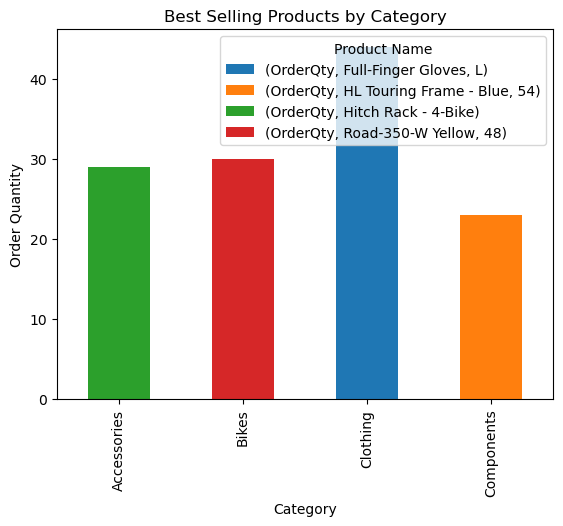

In [178]:
#Visualisering med ett stabeldiagram

#Gruppera data efter kategori och produktnamn
grouped_df = join_df.groupby(['Category', 'ProductName']).sum()

#Skapa staplade stapeldiagram
grouped_df.unstack().plot(kind='bar', stacked=True)

#Anpassa diagram
plt.title('Best Selling Products by Category')
plt.xlabel('Category')
plt.ylabel('Order Quantity')
plt.legend(title='Product Name')
plt.show()

In [193]:
bonus = """ SELECT
      p.FirstName,
      p.LastName,
      s.Bonus
 FROM Person.Person p
 LEFT JOIN Sales.SalesPerson s
     ON s.BusinessEntityID = p.BusinessEntityID
 ORDER BY s.Bonus DESC;
"""

df= pd.read_sql(bonus, con=connection)
df.dropna()

,FirstName,LastName,Bonus
0,Tsvi,Reiter,6700.0
1,Lynn,Tsoflias,5650.0
2,Jae,Pak,5150.0
3,José,Saraiva,5000.0
4,Pamela,Ansman-Wolfe,5000.0
5,Michael,Blythe,4100.0
6,Tete,Mensa-Annan,3900.0
7,Shu,Ito,3550.0
8,David,Campbell,3500.0
9,Jillian,Carson,2500.0


In [194]:
# Konfidensintervall för bonus 

# Beräkna medelvärde och standardavvikelse för bonus
mean_bonus = df['Bonus'].mean()
std_bonus = df['Bonus'].std()

# Beräkna konfidensintervall för bonus
df_bonus = len(df) - 1  # grader av frihet
confidence_interval = stats.t.interval(0.95, df_bonus, loc=mean_bonus, scale=std_bonus/len(df)**0.5)

print('Confidence interval for bonus: ({:.2f}, {:.2f})'.format(confidence_interval[0], confidence_interval[1]))

Confidence interval for bonus: (2827.88, 2890.94)


In [ ]:
# Medelvärdet och standardavvikelsen för bonusen och ett 95% konfidensintervall för bonusen.
# Det verkliga medelvärdet för bonusen har en 95% sannolikhet att ligga någonstans mellan 2827.88 och 2890.94